The Titanic competion is a classification problem: given some info on a passenger, we determine if they survived.

So, two categories represented by the "Survived" boolean columns in the dataset: Yes=1 and Dead=0.

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


# Step 1: Gather the Data

### Checking the format of the data

In [2]:
train_data = pd.read_csv("../input/train.csv", index_col="PassengerId")
test_data = pd.read_csv("../input/test.csv", index_col="PassengerId")

train_data.head()
# test_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Step 2: Prepare the Data

In [4]:
# Separate target from predictors
y = train_data['Survived']
X_full = train_data.drop(['Survived'], axis=1)

In [5]:
(y == 1).sum()

342

In [6]:
# Drop columns with missing values (simplest approach)
# cols_with_na = [col for col in X_full.columns if X_full[col].isnull().any()]
cols_with_na = []
X_reduced = X_full.drop(cols_with_na, axis=1)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
def has_low_cardinality(df, col):
    is_categorical = (df[col].dtype == "object")
    has_low_card = (df[col].nunique() < 10)
    return (is_categorical and has_low_card)

categorical_cols = [col for col in X_reduced.columns if has_low_cardinality(X_reduced, col)]

# Select numerical columns
numerical_cols = [col for col in X_reduced.columns if X_reduced[col].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols

X = X_reduced[my_cols].copy()
X_test = test_data[my_cols].copy()

print("Predictors are : ", my_cols)
print("Numerical cols : ", numerical_cols)
print("Categorical cols : ", categorical_cols)

Predictors are :  ['Sex', 'Embarked', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Numerical cols :  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical cols :  ['Sex', 'Embarked']


In [7]:
X.head()

,Sex,Embarked,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,,,
1,male,S,3,22.0,1,0,7.2500
2,female,C,1,38.0,1,0,71.2833
3,female,S,3,26.0,0,0,7.9250
4,female,S,1,35.0,1,0,53.1000
5,male,S,3,35.0,0,0,8.0500


In [8]:
# Divide data into training and validation subsets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

### Defining the Preprocessing Pipeline

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder(handle_unknown='error', drop='if_binary'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

Checking the preprocessing pipeline

In [10]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)
print(X_train.head())
print(X_train_transformed[:5])

                Sex Embarked  Pclass   Age  SibSp  Parch     Fare
PassengerId                                                      
141          female        C       3   NaN      0      2  15.2458
440            male        S       2  31.0      0      0  10.5000
818            male        C       2  31.0      1      1  37.0042
379            male        C       3  20.0      0      0   4.0125
492            male        S       3  21.0      0      0   7.2500
[[ 3.      0.      0.      2.     15.2458  0.      1.      0.      0.    ]
 [ 2.     31.      0.      0.     10.5     1.      0.      0.      1.    ]
 [ 2.     31.      1.      1.     37.0042  1.      1.      0.      0.    ]
 [ 3.     20.      0.      0.      4.0125  1.      1.      0.      0.    ]
 [ 3.     21.      0.      0.      7.25    1.      0.      0.      1.    ]]


# Step 3: Define the Classifier Model

Model and Pipeline

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf_0 = RandomForestClassifier(
    n_estimators=100,
    random_state=0,
    max_features="sqrt",
    n_jobs=-1
)

pipeline_0 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', clf_0)
])

Training and Validation

In [12]:
pipeline_0.fit(X_train, y_train)

score = pipeline_0.score(X_valid, y_valid)
print(f"Accuracy = {score}")

Accuracy = 0.8491620111731844


# Step 4: Permutation Importance

In [13]:
import eli5
from eli5.sklearn import PermutationImportance
from aux_functions import get_column_names_from_ColumnTransformer

feature_names = get_column_names_from_ColumnTransformer(preprocessor)

perm = PermutationImportance(clf_0, cv='prefit', random_state=1).fit(X_valid_transformed, y_valid)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.1944 ± 0.0164,Sex_male
0.0637 ± 0.0350,Pclass
0.0581 ± 0.0328,Age
0.0369 ± 0.0261,Fare
0.0067 ± 0.0217,Embarked_S
0.0067 ± 0.0109,Parch
0.0034 ± 0.0195,SibSp
0.0034 ± 0.0152,Embarked_C
-0.0011 ± 0.0045,Embarked_Q


In [14]:
perm.feature_importances_

array([ 0.06368715,  0.05810056,  0.00335196,  0.00670391,  0.03687151,
        0.19441341,  0.00335196, -0.00111732,  0.00670391])

# Step 5: Partial Plots

In [15]:
feature_names

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [16]:
X_valid_transformed_pd = pd.DataFrame(X_valid_transformed, columns=feature_names).rename_axis('PassengerId')

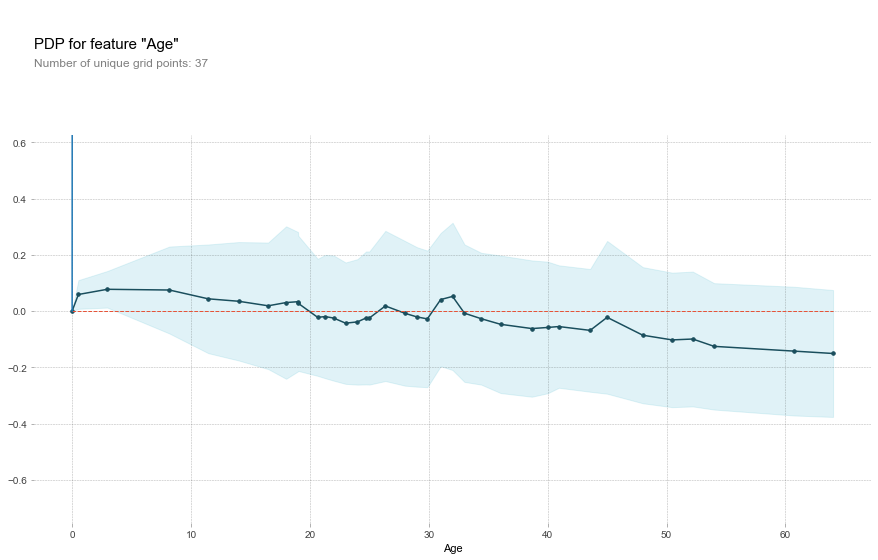

In [17]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(
    model=clf_0,
    dataset=X_valid_transformed_pd,
    model_features=feature_names,
    feature='Age',
    num_grid_points = 50,
    grid_type='percentile',
)

# plot it
pdp.pdp_plot(
    pdp_goals,
    'Age',
#     plot_pts_dist=True,
#     plot_lines=True,
)
plt.plot([0, 100])
plt.show()

On voit que le graph , il est trop beau :D

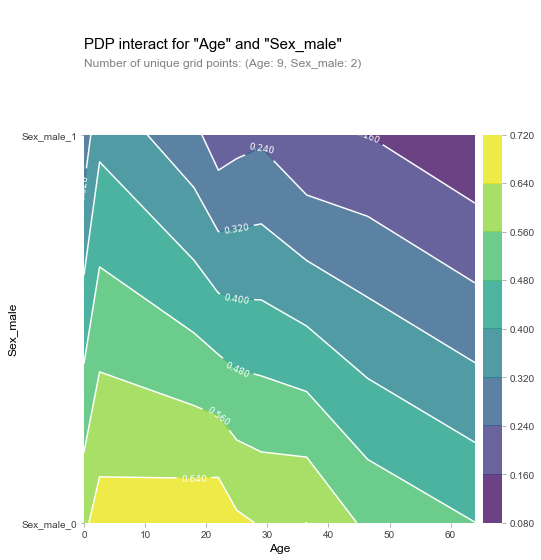

In [18]:
features_to_plot = ['Age', 'Sex_male']
inter1  =  pdp.pdp_interact(
    model=clf_0,
    dataset=X_valid_transformed_pd,
    model_features=feature_names,
    features=features_to_plot,
)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

# Step 6: SHAP Values

## SHAP Values Review

In [19]:
import shap  # package used to calculate Shap values

In [20]:
data_for_prediction = pd.DataFrame(
    preprocessor.transform(
        X_valid.sample(n=1, random_state=1)
    ),
    columns=feature_names
)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf_0)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(
    explainer.expected_value[1], # second class = Probaility to survive
    shap_values[1], # second shap_value associated with the state Survived=1
    data_for_prediction,
    out_names='P(Survived)',
)

# Step 7: Advanced Useds of SHAP Values

In [21]:
import shap  # package used to calculate Shap values

In [22]:
data_for_prediction = pd.DataFrame(
    preprocessor.transform(X_valid),
    columns=feature_names
)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf_0)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(
    explainer.expected_value[1],
    shap_values[1],
    data_for_prediction,
    out_names='P(Survived)',
)

## Summary Plots

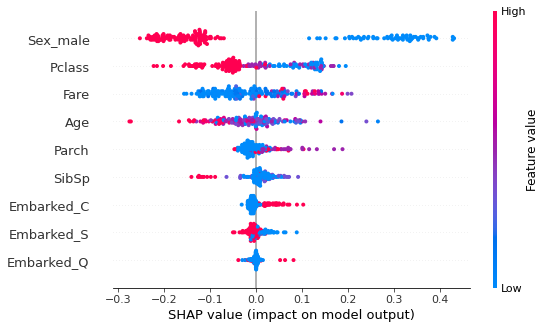

In [23]:
# print(f'Current Label Shown: {list_of_labels[current_label.value]}\n')
shap.summary_plot(shap_values[1], data_for_prediction)


## SHAP Dependence Contribution Plots

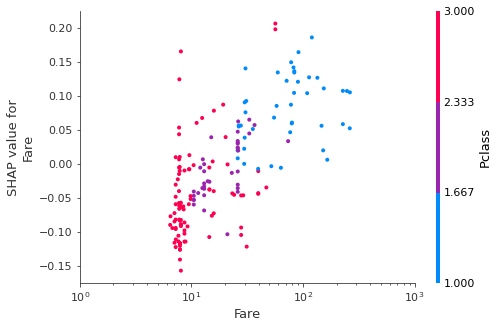

In [24]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.dependence_plot(
    'Fare', shap_values[1], data_for_prediction,
    interaction_index='Pclass',
    show=False,
)
plt.xscale('log')
plt.xlim(1, 1000)
plt.show()